In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [25]:
def onehot_encode(values):
    # integer encode
    global label_encoder
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    return onehot_encoded

In [26]:
def load_data(problem_type):
    if problem_type == "classification":
        train_data = np.genfromtxt("./data/classification/data.three_gauss.train.10000.csv",
                                    delimiter=',', skip_header=True, encoding="utf8")
        test_data = np.genfromtxt("./data/classification/data.three_gauss.test.1000.csv",
                                  delimiter=',', skip_header=True, encoding="utf8")
    elif problem_type == "regression":
        train_data = np.genfromtxt("./data/regression/data.activation.train.1000.csv",
                                   delimiter=',', skip_header=True, encoding="utf8")
        test_data = np.genfromtxt("./data/regression/data.activation.test.100.csv",
                                  delimiter=',', skip_header=True, encoding="utf8")

    train_x = train_data[:, :-1]
    test_x = test_data[:, :-1]
    train_y = train_data[:,-1:]

    if problem_type == "classification":
        train_values = np.array(train_data[:,-1])
        train_y = onehot_encode(train_values)        
   # print(train_y)

    test_y = test_data[:, -1:]
    if problem_type == "classification":
        test_values = np.array(test_data[:,-1])
        test_y = onehot_encode(test_values)
        
    return train_x.T, train_y.T, test_x.T, test_y.T

In [27]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [28]:
def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    dZ = dA * sigmoid(Z) * sigmoid(1-Z)

    return dZ

In [29]:
def relu(Z):
    return np.maximum(Z, 0)

In [30]:
def relu_backward(dA, activation_cache):
    Z = activation_cache
    Z = np.heaviside(Z, 0)

    return dA * Z

In [31]:
def identity(Z):
    return Z

In [32]:
def identity_backward(dA, activation_cache):
    Z = activation_cache
    dZ = dA * 1

    return dZ

In [33]:
def initialize_parameters(layer_dims):
    params = {}

    for i in range(1, len(layer_dims)):
        params['W' + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01
        params['b' + str(i)] = np.zeros([layer_dims[i], 1])
        params['prevDeltaW' + str(i)] = 0
        params['prevDeltab' + str(i)] = 0

    return params

In [34]:
def linear_activation_forward(A, W, b, activation):
    Z = np.dot(W, A) + b
    linear_cache = (A, W, b)
    activation_cache = Z
    
    if activation == "sigmoid":
        A = sigmoid(Z)
    elif activation == "relu":
        A = relu(Z)
    elif activation == "identity":
        A = identity(Z)

    return A, (linear_cache, activation_cache)


In [35]:
def model_forward(X, params, problem_type, activation_function):
    caches = []
    L = len(params) // 4 # Params contains W, b, deltaW and deltab info
    A = X

    # Hidden layers
    for i in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, params['W' + str(i)], params['b' + str(i)], activation_function)
        caches.append(cache)

    # Output layer
    outputFunction = "sigmoid" if problem_type == "classification" else "identity"
    AL, cache = linear_activation_forward(A, params['W' + str(L)], params['b' + str(L)], outputFunction)
    caches.append(cache)

    return AL, caches

In [36]:
def compute_cost(A, Y, problem_type):
    if problem_type == "classification":
        cost = -1 / Y.shape[1] * np.sum(np.multiply(Y, np.log(A)) + np.multiply((1-Y), np.log(1-A)))
    else:
        cost = 1 / Y.shape[1] * np.sum(np.power(Y-A,2))
    return np.squeeze(cost)

In [37]:
def linear_backward(dZ, cache):
    A, W, b = cache
    m = A.shape[1]
    
    dW = 1/m* np.dot(dZ, A.T)
    db = 1/m* np.sum(dZ, axis=1, keepdims=True)
    dA = np.dot(W.T, dZ)

    return dA, dW, db

In [38]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid": 
        dZ = sigmoid_backward(dA, activation_cache)
    elif activation == "identity":
        dZ = identity_backward(dA, activation_cache)

    dA, dW, db = linear_backward(dZ, linear_cache)
    return dA, dW, db

In [39]:
def model_backward(A, Y, caches, problem_type, activation_function):
    grads = {}
    L = len(caches)
    m = A.shape[1]
    Y = Y.reshape(A.shape)

    if problem_type == "clasification":
        dA = - (np.divide(Y, A) - np.divide(1 - Y, 1 - A))
        outputFunction = "sigmoid"
    else:
        dA = 2 * (A - Y)
        outputFunction = "identity"

    # Last layer
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dA, current_cache, outputFunction)

    # Rest of layers
    for i in reversed(range(L-1)):
        current_cache = caches[i]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(i+1)], current_cache, activation_function)
        grads["dA" + str(i)] = dA_prev_temp
        grads["dW" + str(i + 1)] = dW_temp
        grads["db" + str(i + 1)] = db_temp
    
    return grads

In [63]:
def update_parameters(parameters, grads, learning_rate, momentum_rate):
    L = len(parameters) // 4

    for l in range(L):
        deltaW = - learning_rate * grads["dW" + str(l+1)] + momentum_rate * parameters['prevDeltaW' + str(l+1)]
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] + deltaW
        parameters['prevDeltaW' + str(l+1)] = deltaW

        deltab = - learning_rate * grads["db" + str(l+1)] + momentum_rate * parameters['prevDeltab' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] + deltab
        parameters['prevDeltab' + str(l+1)] = deltab
        

    return parameters

In [41]:
def train_model(X, Y, layers_dims, learning_rate, momentum_rate, num_iterations, problem_type, activation_function, print_cost=True, print_interval=100):
    costs = []
    parameters = initialize_parameters(layers_dims)

    for i in range(0, num_iterations):
        # Forward propagation
        A, caches = model_forward(X, parameters, problem_type, activation_function)
        # Compute cost
        cost = compute_cost(A, Y, problem_type)
        # Backward propagation
        grads = model_backward(A, Y, caches, problem_type, activation_function)
        # Update params
        parameters = update_parameters(parameters, grads, learning_rate, momentum_rate)
        #print(parameters["W3"])
        if print_cost and i % print_interval == 0:
            print("Iteration %i: cost: %f" % (i, cost))
            costs.append(cost)

    return parameters

In [42]:
def predict(params, X, Y, problem_type, activation_function):
    global label_encoder
    A, cache = model_forward(X, params, problem_type, activation_function)
    if problem_type == "classification":
        labels = label_encoder.inverse_transform(np.argmax(A, axis=0))

        Y_decoded = label_encoder.inverse_transform(np.argmax(Y, axis=0))
        percentage_correct = (labels == Y_decoded).sum()/float(labels.size) * 100.
    else:
        labels = A
        percentage_correct = compute_cost(A, Y, problem_type)
        Y_decoded = Y
        plt.plot(X.T, Y.T, "-", label="input")
        plt.plot(X.T, A.T, "-", label="output")
        plt.legend()
        plt.show()
    #print(labels)
   # print(Y_decoded)
    
    return labels, percentage_correct


Iteration 0: cost: 16667.224932
Iteration 1000: cost: 20.802690
Iteration 2000: cost: 10.540159
Iteration 3000: cost: 7.067412
Iteration 4000: cost: 5.186939
Iteration 5000: cost: 3.588663


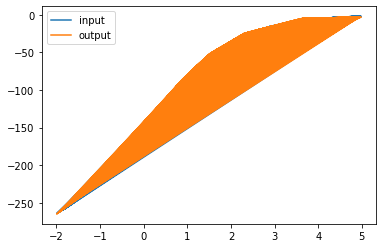

Correctness for train set: 1.8475112888982352


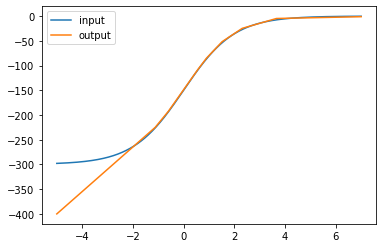

Correctness for test set: 734.4849741522078


In [71]:
# Set PWD when working on jupyter notebook
os.chdir("D:/Projects/MGU/Projekt1/")

# Set seed
SEED = 100
np.random.seed(SEED)

# Load data
label_encoder=None
train_x, train_y, test_x, test_y = load_data("regression")

# Set model parameters
layers_dims = [train_x.shape[0], 10, 5, train_y.shape[0]]
num_iterations = 6000
learning_rate = 0.001
momentum_rate = 0.09
print_interval = 1000
problem_type = "regression"
activation_function = "relu"

# Train model
params = train_model(train_x, train_y, layers_dims, learning_rate, momentum_rate, num_iterations, problem_type, activation_function, print_cost=True, print_interval = print_interval)    

# Predict
labels, correctness = predict(params, train_x, train_y, problem_type, activation_function)
print("Correctness for train set: " + str(correctness))
labels, correctness = predict(params, test_x, test_y, problem_type, activation_function)
print("Correctness for test set: " + str(correctness))